In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, IncrementalPCA, SparsePCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from scipy.spatial.distance import cosine
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy import sparse
import pickle
from lightgbm import LGBMClassifier
from itertools import combinations
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
def get_vectors(data, vect_type='count', **voc_params):
    if vect_type == 'count':
        vectorizer = CountVectorizer(**voc_params)
    elif vect_type == 'tfidf':
            vectorizer = TfidfVectorizer(min_df=2)
    data_vect = vectorizer.fit_transform(data.fillna('')).todense()
    scaler = StandardScaler()
    data_vect = scaler.fit_transform(data_vect)
    return data_vect

def make_pca(data_vect):
    pca = PCA()
    pca.fit(data_vect)
    n_c = (pca.explained_variance_ratio_.cumsum() < 0.95).sum()
    pca = PCA(n_components=n_c)
    data_vect = pca.fit_transform(data_vect)
    return data_vect

def get_devs(df, n_vecs):
    df_list = []
    for i in tqdm(df['group_id'].unique(), total=129):
        df_i = df[df['group_id'] == i]
        vect_i = np.array(df_i.loc[:, [f'{j}_f' for j in range(n_vecs)]])
        mean_i = np.mean(vect_i, axis=0)
        df_i['dev'] = np.apply_along_axis(lambda x: cosine(x, mean_i), axis=1, arr=vect_i)
        df_list.append(df_i)
    df_with_dev = pd.concat(df_list)
    df = df_with_dev.drop([f'{i}_f' for i in range(n_vecs)], 1)
    return df

def show_hist(df, column='dev'):
    plt.hist(df[df['target'] == 0][column].fillna(0), bins=100, normed=True, label='Out of group')
    plt.hist(df[df['target'] == 1][column].fillna(0), bins=100, normed=True, alpha=0.7, label='In group')
    plt.title('dev distribution')
    plt.legend()

def get_th(proba, y_test):
    scores = []
    ths = np.arange(0.1, 0.9, 0.1)
    for i in ths:
        scores.append(f1_score(y_test, (proba > i)[:, 1]))
    ind = scores.index(max(scores))
    th = np.arange(0.1, 0.9, 0.1)[ind]
    score = f1_score((proba > th)[:, 1], y_test)
    return score, th

In [4]:
titles = pd.read_csv('data/clean_titles.csv')

In [4]:
headers = pd.read_csv('data/all_headers.tsv', '\t')

In [5]:
voc_params = {'min_df': 5, 'max_df': 0.8}
vect_count = get_vectors(titles['clean_title'], **voc_params)

In [5]:
voc_params = {'min_df': 5, 'max_df': 0.8}
vect_headerst = get_vectors(headers['headers'], **voc_params)

In [62]:
scaler = StandardScaler()
vect_count = scaler.fit_transform(vect_count)

In [81]:
scaler = StandardScaler()
vect_headerst = scaler.fit_transform(vect_headerst)

In [6]:
titles_count = titles.join(pd.DataFrame(vect_count, columns=[f'{i}_f' for i in range(vect_count.shape[1])]))

In [ ]:
headers_count = titles.join(pd.DataFrame(vect_headerst, columns=[f'{i}_f' for i in range(vect_headerst.shape[1])]))

In [ ]:
df_train = pd.read_csv('data/train_groups.csv')

In [7]:
df_test = pd.read_csv('data/test_groups.csv')

In [49]:
df_train_count = pd.merge(df_train, titles_count, how='left', on='doc_id')

In [8]:
df_test_count = pd.merge(df_test, titles_count, how='left', on='doc_id')

In [ ]:
df_train_headers = pd.merge(df_train, headers_count, how='left', on='doc_id')

In [34]:
df_train_count.head()

,pair_id,group_id,doc_id,target,clean_title,0_f,1_f,2_f,3_f,4_f,...,4212_f,4213_f,4214_f,4215_f,4216_f,4217_f,4218_f,4219_f,4220_f,4221_f
0,1,1,15731,0,ваз замена подшипник ступица нива,-0.016921,-0.020081,-0.02094,-0.013376,-0.036944,...,-0.030514,-0.060521,-0.019842,-0.01269,-0.013376,-0.013376,-0.01269,-0.025513,-0.036522,-0.015988
1,2,1,14829,0,ваз опт сочи сравнивать цена купить потребител...,-0.016921,-0.020081,-0.02094,-0.013376,-0.036944,...,-0.030514,-0.060521,-0.019842,-0.01269,-0.013376,-0.013376,-0.01269,-0.025513,-0.036522,-0.015988
2,3,1,15764,0,купить ступица лада калина трансмиссия переход...,-0.016921,-0.020081,-0.02094,-0.013376,-0.036944,...,-0.030514,-0.060521,-0.019842,-0.01269,-0.013376,-0.013376,-0.01269,-0.025513,-0.036522,-0.015988
3,4,1,17669,0,классика,-0.016921,-0.020081,-0.02094,-0.013376,-0.036944,...,-0.030514,-0.060521,-0.019842,-0.01269,-0.013376,-0.013376,-0.01269,-0.025513,-0.036522,-0.015988
4,5,1,14852,0,ступица нива замена подшипник свой рука,-0.016921,-0.020081,-0.02094,-0.013376,-0.036944,...,-0.030514,-0.060521,-0.019842,-0.01269,-0.013376,-0.013376,-0.01269,-0.025513,-0.036522,-0.015988


In [52]:
data = []
for group_id in tqdm(range(1, 129), total=128):
    sample = df_train_count[df_train_count['group_id'] == group_id]
    summary = np.array(sample.loc[:, [f'{i}_f' for i in range(4222)]])
    pairwise = pd.DataFrame(
        squareform(pdist(summary, metric='cosine')),
#         columns = [f'{i}_pair' for i in range(1, sample.shape[0] + 1)],
#         index = [f'{i}_pair' for i in range(1, sample.shape[0] + 1)]
        columns = sample['pair_id'],
        index = sample['pair_id']
    )
    pairwise = pairwise.replace(0, np.nan)
    pairwise = pairwise.describe().T
    pairwise = pairwise.reset_index()
#     pairwise['index'] = pairwise['index'].apply(lambda x: int(x.split('_')[0]))
    data.append(pairwise)
data_count = pd.concat(data)

In [10]:
data = []
groups = df_test_count['group_id'].unique()
for group_id in tqdm(groups, total=groups.shape[0]):
    sample = df_test_count[df_test_count['group_id'] == group_id]
    summary = np.array(sample.loc[:, [f'{i}_f' for i in range(4222)]])
    pairwise = pd.DataFrame(
        squareform(pdist(summary, metric='cosine')),
#         columns = [f'{i}_pair' for i in range(1, sample.shape[0] + 1)],
#         index = [f'{i}_pair' for i in range(1, sample.shape[0] + 1)]
        columns = sample['pair_id'],
        index = sample['pair_id']
    )
    pairwise = pairwise.replace(0, np.nan)
    pairwise = pairwise.describe().T
    pairwise = pairwise.reset_index()
#     pairwise['index'] = pairwise['index'].apply(lambda x: int(x.split('_')[0]))
    data.append(pairwise)
data_test = pd.concat(data)

In [91]:
data = []
for group_id in tqdm(range(1, 129), total=128):
    sample = df_train_headers[df_train_headers['group_id'] == group_id]
    summary = np.array(sample.loc[:, [f'{i}_f' for i in range(18067)]])
    pairwise = pd.DataFrame(
        squareform(pdist(summary, metric='cosine')),
#         columns = [f'{i}_pair' for i in range(1, sample.shape[0] + 1)],
#         index = [f'{i}_pair' for i in range(1, sample.shape[0] + 1)]
        columns = sample['pair_id'],
        index = sample['pair_id']
    )
    pairwise = pairwise.replace(0, np.nan)
    pairwise = pairwise.describe().T
    pairwise = pairwise.reset_index()
#     pairwise['index'] = pairwise['index'].apply(lambda x: int(x[0]))
    data.append(pairwise)
data_headers = pd.concat(data)

In [57]:
df_train_count = pd.merge(df_train, data_count, how='left', on='pair_id')

In [58]:
df_train_count.shape

(11690, 12)

In [13]:
df_test_count = pd.merge(df_test, data_test, how='left', on='pair_id')
df_test_count.head()

,pair_id,group_id,doc_id,count,mean,std,min,25%,50%,75%,max
0,11691,130,6710,97.0,0.924379,0.170746,0.407721,0.997128,1.000808,1.001945,1.007153
1,11692,130,4030,97.0,0.990702,0.041365,0.665101,0.994925,1.001045,1.001948,1.007048
2,11693,130,5561,97.0,0.894727,0.206106,0.277460,0.854345,1.001470,1.002502,1.019193
3,11694,130,4055,97.0,0.872997,0.247342,0.105951,0.819164,1.000056,1.000967,1.005470
4,11695,130,4247,97.0,0.977477,0.084223,0.510155,0.995918,1.000524,1.001139,1.004164


In [12]:
df_train_count = df_train_count.drop(['index'], 1)

In [59]:
df_train_count.head()

,pair_id,group_id,doc_id,target,count,mean,std,min,25%,50%,75%,max
0,1,1,15731,0,100.0,0.761555,0.250863,0.062504,0.626651,0.834145,1.000496,1.003004
1,2,1,14829,0,101.0,0.925562,0.128857,0.452345,0.880770,1.000874,1.001798,1.016542
2,3,1,15764,0,101.0,0.911651,0.151603,0.439112,0.860085,1.000562,1.001146,1.010765
3,4,1,17669,0,101.0,0.999378,0.004346,0.970347,0.999705,1.000198,1.000562,1.001958
4,5,1,14852,0,101.0,0.792380,0.264225,0.025196,0.620202,0.900059,1.001198,1.004416


In [60]:
df_train_count['pair_id'].unique().shape

(11690,)

In [61]:
df_train_count.to_csv('data/dist_titles.csv', index=False)

In [14]:
df_test_count.to_csv('data/test_dist_titles.csv', index=False)

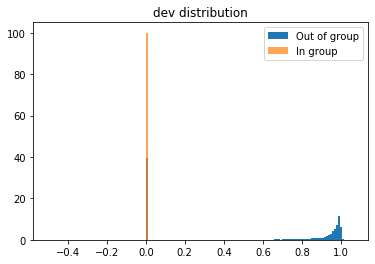

In [95]:
show_hist(df_train_headers, 'mean')

In [96]:
def linear_model_cross_val_score(model, df, train_subset=['dev'], cv=5):
    indices = df['group_id'].unique()
    result = []
    ths = 0
    for i in range(cv):
        train_ids = np.random.choice(indices, indices.shape[0] // 2, replace=False)
        test_ids = indices[~np.isin(indices, train_ids)]
        train_data = df[df['group_id'].isin(train_ids)]
        test_data = df[df['group_id'].isin(test_ids)]
        model.fit(train_data.loc[:, train_subset].fillna(0), train_data['target'])
        proba = model.predict_proba(test_data.loc[:, train_subset].fillna(0))
        score, th = get_th(proba, test_data['target'])
        ths += th
        result.append(score)
    return sum(result) / len(result), ths / len(result)

In [100]:
model = LogisticRegression(C=1)
linear_model_cross_val_score(model, df_train_headers, ['mean', 'min', 'max', '25%', '50%', '75%'], 10)

(0.3195835113999207, 0.09999999999999999)

In [78]:
model = LogisticRegression()
model.fit(df_train.loc[:, ['mean', 'min', 'max', 'std']].fillna(0), df_train['target'])
proba = model.predict_proba(df_train.loc[:, ['mean', 'min', 'max', 'std']].fillna(0))
print(get_th(proba, df_train['target']))

(0.44688206355537824, 0.1)


In [105]:
model = LGBMClassifier(max_depth=1, n_estimators=1000)
linear_model_cross_val_score(model, df_train_headers, ['mean', 'min', 'max', '25%', '50%', '75%'], 10)

(0.25773191401861884, 0.09999999999999999)

# Посмотрим, что нам даст IOU

In [106]:
titles = pd.read_csv('data/clean_titles.csv')
df_train = pd.read_csv('data/train_groups.csv')

In [107]:
df_train = pd.merge(df_train, titles, how='left', on='doc_id')

In [143]:
def jaccard_similarity(query, document):
    query = query[0]
    document = document[0]
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    if union:
        return len(intersection) / len(union)
    else:
        return 0

In [144]:
data = []
for group_id in tqdm(range(1, 129), total=128):
    sample = df_train[df_train['group_id'] == group_id]
    summary = np.array(sample.loc[:, ['clean_title']].fillna(''))
    pairwise = pd.DataFrame(
        squareform(pdist(summary, metric=jaccard_similarity)),
        columns = [f'{i}_pair' for i in range(1, sample.shape[0] + 1)],
        index = [f'{i}_pair' for i in range(1, sample.shape[0] + 1)]
    )
    pairwise = pairwise.describe().T
    pairwise = pairwise.reset_index()
    pairwise['index'] = pairwise['index'].apply(lambda x: int(x[0]))
    data.append(pairwise)
data = pd.concat(data)

In [149]:
df_train_jaccard = pd.merge(df_train, data, how='left', left_on='pair_id', right_on='index')

In [150]:
model = LogisticRegression(C=1)
linear_model_cross_val_score(model, df_train_jaccard, ['mean', 'min', 'max', '25%', '50%', '75%'], 10)

(0.3410368106615488, 0.09999999999999999)

In [161]:
def linear_model_cross_val_score(model, df, train_subset=['dev'], cv=5):
    indices = df['group_id'].unique()
    result = []
    ths = 0
    for i in range(cv):
        train_ids = np.random.choice(indices, indices.shape[0] // 2, replace=False)
        test_ids = indices[~np.isin(indices, train_ids)]
        train_data = df[df['group_id'].isin(train_ids)]
        test_data = df[df['group_id'].isin(test_ids)]
        model.fit(train_data.loc[:, train_subset].fillna(0), train_data['target'])
        return roc_auc_score(test_data['target'], model.predict_proba(test_data.loc[:, train_subset].fillna(0))[:, 1])

In [162]:
model = LogisticRegression(C=1)
linear_model_cross_val_score(model, df_train_jaccard, ['mean', 'min', 'max', '25%', '50%', '75%'], 10)

0.5